# Базовое решение задачи оценки качества изображений

### О датасете и таргете

Датасет состоит из 16.5K искаженных изображений, соответствующих 3K референсным изображениям. Все изображения хранятся в формате png. Датасет уже поделен на train и test. Файлы именуются так: RR_D.png, где RR - номер соответствующего референса (сами референсы в датасет не включены), D - тип искажения. Всего используется 5 типов искажений, таких как размытие по Гауссу, сжатие, линейное преобразование, аддитивный гауссовский шум (поканально и в компоненте яркости).

Файл train.csv содержит PSNR для всех искаженных картинок. Чем ниже эта метрика, тем хуже картинка относительно рефересна.

В задании требуется предсказать PSNR (не имея референса).

Примеры картинок из датасета ниже:

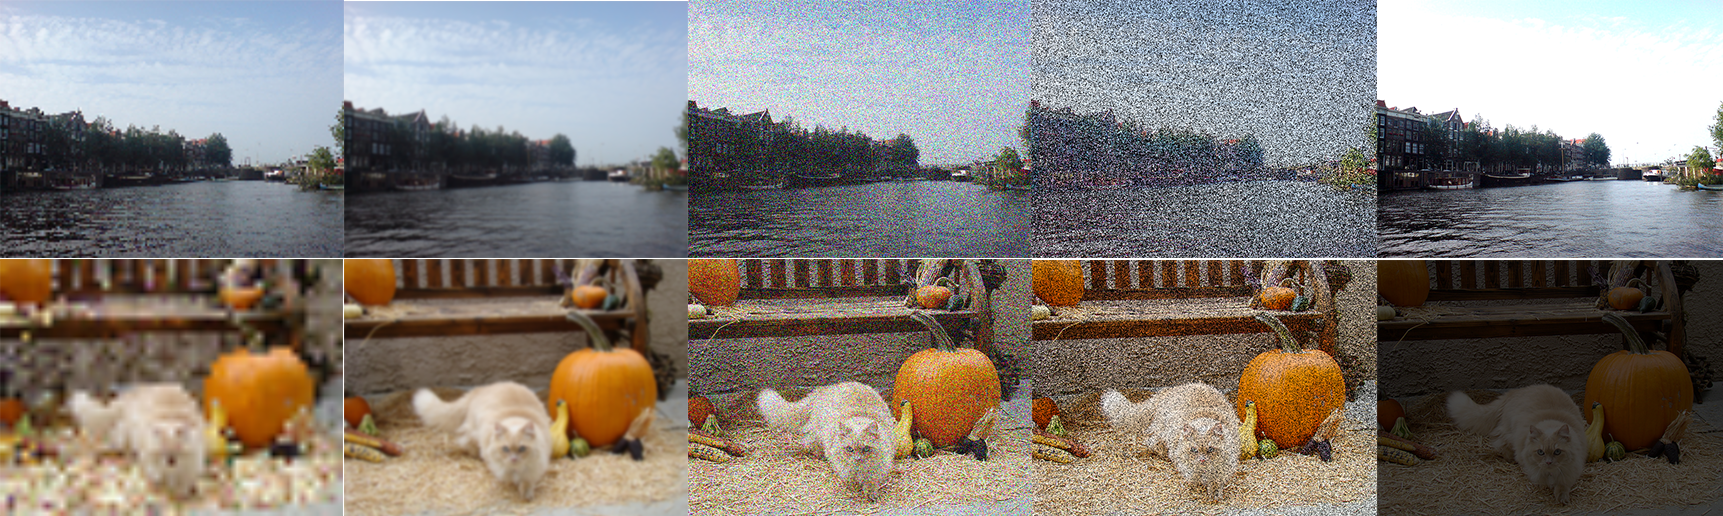

### Загрузка исходных данных

In [1]:
import os
from glob import glob
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

In [27]:
path_to_train_csv = 'data/train.csv'
train_df = pd.read_csv(path_to_train_csv)

In [3]:
train_df.head()

,img_name,PSNR
0,100083_1.png,29.543164
1,100083_2.png,27.894582
2,100083_3.png,29.350353
3,100083_4.png,27.775248
4,100083_5.png,34.358442


In [28]:
imgs = []
for img_name in tqdm(train_df["img_name"].values, total=len(train_df)):
    img = cv2.imread(os.path.join('data/train', img_name))
    imgs.append(img)

  0%|          | 0/13210 [00:00<?, ?it/s]

In [29]:
path_to_test_csv = 'data/sample_submission.csv' # В sample_submission хранятся имена файлов тестовой выборки
test_df = pd.read_csv(path_to_test_csv)

In [30]:
# Загрузка тестовой выборки
# Можно запустить ее сразу, а можно в конце (чтобы сейчас время не тратить)
test_imgs = []
for img_name in tqdm(test_df.img_name.values, total=len(test_df)):
    img = cv2.imread(os.path.join('data/test', img_name))
    test_imgs.append(img)

  0%|          | 0/3310 [00:00<?, ?it/s]

In [31]:
imgs = np.array(imgs)

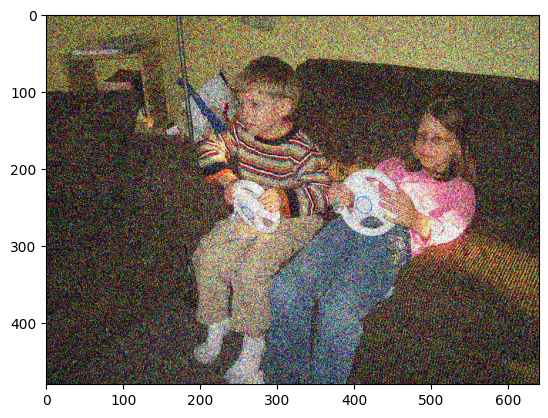

In [32]:
# Посмотрим пример картинки из датасета, который мы загрузили
ind = np.random.randint(0, len(imgs))
plt.imshow(cv2.cvtColor(imgs[ind], cv2.COLOR_BGR2RGB))
plt.show()

In [33]:
# Получение названий референсных картинок
ref_names = set()
for img_name in train_df.img_name.values:
    ref_names.add(img_name.split('_')[0])
ref_names = sorted(list(ref_names))
random.seed(7)
random.shuffle(ref_names)

In [34]:
# Деление на train и val
train_size = 0.8

train_names = []
train_ids = []
val_names = []
val_ids = []
for i, img_name in enumerate(train_df.img_name.values):
    ref = img_name.split('_')[0]
    if ref in ref_names[:int(train_size * len(ref_names))]:
        train_names.append(img_name)
        train_ids.append(i)
    else:
        val_names.append(img_name)
        val_ids.append(i)
print(f"Train size: {len(train_names)}")
print(f"Validation size: {len(val_names)}")

Train size: 10565
Validation size: 2645


In [35]:
tr_df = train_df.set_index('img_name').loc[train_names]
val_df = train_df.set_index('img_name').loc[val_names]


### Получение признаков

In [83]:
# Для бейзлайна посчитаем всего 2 признака: яркость и резкость изображений. Резкость можно считать разными способами, здесь один из них
from skimage.feature import hog
from joblib import Parallel, delayed


def brightness(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v = hsv[..., 2].mean()
    return v / 255 # normalization

def sharpness_grad_based(img):
    gradx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    grady = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
    grad = np.sqrt(gradx * gradx + grady * grady)
    return grad[1: -1, 1: -1].mean()

def saturation(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    s = hsv[..., 1].mean()
    return s / 255 

# Гистограмма ориентированных градиентов (HOG): Эта техника может выявлять 
# текстурные особенности изображения через распределение ориентированных 
# градиентов в различных ячейках изображения.
def hog_features(img):
    hog_features, _ = hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    return hog_features.mean()

# Гистограммы цветовых каналов: Извлечение статистики из цветовых каналов 
# изображения может быть полезным для определения изменений в цветовой 
# информации из-за искажений.
def color_histogram(img):
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist.mean()

# Laplacian of Gaussian (LoG): Этот метод может помочь выявить детали и 
# текстуры в изображении.
def laplacian_of_gaussian(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_lap = cv2.Laplacian(img_gray, cv2.CV_64F, ksize=3)
    img_log = cv2.GaussianBlur(np.abs(img_lap), (3, 3), 0)
    return img_log.mean()

def image_contrast(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([img_gray], [0], None, [256], [0, 256])
    contrast = np.sum(hist * np.square(np.arange(256) - 128))
    return contrast / (img_gray.shape[0] * img_gray.shape[1])

# def get_iqa_fv(img):
#     fv = np.empty((0,))
#     fv = np.append(fv, brightness(img))
#     fv = np.append(fv, sharpness_grad_based(img))
#     fv = np.append(fv, saturation(img))
#     fv = np.append(fv, hog_features(img))
#     fv = np.append(fv, color_histogram(img))
#     fv = np.append(fv, laplacian_of_gaussian(img))
#     fv = np.append(fv, image_contrast(img))
#     return fv

# def get_features(list_of_imgs):
#     features =[]
#     for img in tqdm(list_of_imgs):
#         features.append(get_iqa_fv(img))
#     features = np.vstack(list(features))
#     return features

def get_features_parallel(list_of_imgs):
    def get_iqa_fv_parallel(img):
        fv = np.empty((0,))
        fv = np.append(fv, brightness(img))
        fv = np.append(fv, sharpness_grad_based(img))
        fv = np.append(fv, saturation(img))
        fv = np.append(fv, hog_features(img))
        fv = np.append(fv, color_histogram(img))
        fv = np.append(fv, laplacian_of_gaussian(img))
        fv = np.append(fv, image_contrast(img))
        return fv
    
    features = Parallel(n_jobs=-1, verbose=10)(delayed(get_iqa_fv_parallel)(img) for img in tqdm(list_of_imgs))
    features = np.vstack(features)
    return features


# print('Подсчет признаков обучающей выборки...')
# X_train = get_features(imgs[train_ids])
# print('Подсчет признаков валидационной выборки...')
# X_val = get_features(imgs[val_ids])
# X_train.shape, X_val.shape

print('Подсчет признаков обучающей выборки...')
X_train_parallel = get_features_parallel(imgs[train_ids])
print('Подсчет признаков валидационной выборки...')
X_val_parallel = get_features_parallel(imgs[val_ids])

Подсчет признаков обучающей выборки...


  0%|          | 0/10565 [00:01<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  

Подсчет признаков валидационной выборки...


  0%|          | 0/2645 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  

### Нормализация данных

Для улучшения качества модели данные можно нормализовать. Таргеты можно привести к диапазону от 0 до 1, признаки можно стандартизовать. Если делать какие то манипуляции с данными, необходимо не забывать  сделать то же самое с тестовой выборкой. При манипуляции с таргетом необходимо в конце сделать обратное преобразование предсказаний (потому что проверяющая система ничего не знает о ваших методах нормализации).

In [90]:
y_train = tr_df.PSNR.values
y_val = val_df.PSNR.values

# Здесь можно нормализовать данные (опционально)
# X_train = ...
# X_val = ...

## Обучение и тестирование модели

Как уже было сказано выше, если признаки хорошие, то, возможно, даже самая простая модель справится. Возьмем линейную регрессию.

In [102]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_parallel, y_train)
y_pred = model.predict(X_val_parallel)

# Введем метрики оценки качества модели
def mse(y_true, y_pred):
    return ((y_true - y_pred)**2).mean()
def mae(y_true, y_pred):
    return (np.abs(y_true - y_pred)).mean()


# Оценим нашу модель на валидационной выборке:
print(f"MSE = {mse(y_val, y_pred)} \nMAE = {mae(y_val, y_pred)}")

MSE = 3.143364918258178 
MAE = 1.0335157407940292


In [125]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42)
model.fit(X_train_parallel, y_train)
y_pred = model.predict(X_val_parallel)

# Введем метрики оценки качества модели
def mse(y_true, y_pred):
    return ((y_true - y_pred)**2).mean()
def mae(y_true, y_pred):
    return (np.abs(y_true - y_pred)).mean()

# Оценим нашу модель на валидационной выборке:
print(f"MSE = {mse(y_val, y_pred)} \nMAE = {mae(y_val, y_pred)}")

MSE = 2.931280829483081 
MAE = 0.9288364433307776


Анализировать mse и mae в данном случае не очень удобно, так как таргет находится в странном диапазоне. Поэтому рекомендую обратить внимание на пункт "нормализация данных".

## Подготовка ответов

In [126]:
# генерация фичей
print('Подсчет признаков тестовой выборки...')
X_test = get_features_parallel(test_imgs)

# нормализация/стандартизация, если нужна
# <ваш код>

y_pred = model.predict(X_test)

# обратная нормализация стандартизация ответов, если нужна

Подсчет признаков тестовой выборки...


  0%|          | 0/3310 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  

In [127]:
import pandas as pd

# Сохранение результатов
ans = pd.DataFrame({'img_name': test_df.img_name.values, 'PSNR': y_pred})
ans.to_csv('predict.csv', index=False)

In [128]:
ans.head()

,img_name,PSNR
0,100090_1.png,29.264728
1,100090_2.png,27.886076
2,100090_3.png,27.956174
3,100090_4.png,29.919000
4,100090_5.png,29.919000


# Подсказки и советы по улучшению



*   Самое основное, что можно сделать - это добавить новых признаков. Посмотрите на датасет. Как вы думаете, какими признаками выделяются картинки очень плохого качества (разные признаки могут отвечать за разные типы  искажений). Попробуйте добавить насыщенность, экспозицию, контраст изображения. Можно еще придумать что-нибудь с балансом цвета, и проч.
* Можно использовать не только сами признаки, но и их квадраты и произведения (или другие нелинейные функции от них)
* Можно подбирать параметры линейной регрессии. Можно добавить регуляризацию
* Можно использовать другие модели, например, бустинг или случайный лес
* В конце, перед сабмитом, выбранную модель можно переобучить заново на всем тренировочном датасете (без выделения валидационной подвыборки)



